In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import itertools
import re
import collections
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


In [2]:
df = pd.read_parquet("df.parquet")

In [3]:
df

,record_id,product,description,sub_category,brand,company,company_parent,market_country,store_name,store_type,import_status,unit_price,percentile,premium,doc_vec,description_token,description_wv
0,7146579,Nocturnal Nectar Bio-Fermented Facial Essence,"Named after an English wild-flower meadow, Aml...",Face/Neck Care,Amly,Amly Botanicals,Amly Botanicals,Germany,None,None,Imported,402266.00,1.000000,1,"[-0.33388913, 2.1469963, 0.96274215, -0.878904...","[name, english, wild, flower, meadow, amli, de...","[[-0.051982604, -0.08290577, 0.3159616, 0.0085..."
1,6444419,Micro Needling Pimple Patches,Vice Reversa aims to focus on targeted deliver...,Face/Neck Care,Vice Reversa,A Beauty Story,A Beauty Story,UK,Victoria Health,Internet/Mail Order,Imported,265200.00,0.999939,1,"[0.59363365, 2.8043451, 0.6298298, -1.0089695,...","[vice, reversa, aim, focu, target, deliveri, s...","[[0.3694772, -0.57862556, -2.0269456, -0.64512..."
2,6993711,Capsules Protection Totale Face Treatment Oil,The Jean d'Arcel Renovar collection is said to...,Face/Neck Care,Jean d'Arcel Renovar,Jean d'Arcel Cosmétique,Jean d'Arcel Cosmétique,Germany,Feel-Beauty.de,Internet/Mail Order,Not imported,242950.00,0.999878,1,"[0.39346665, -1.5720978, 0.32630467, -0.300545...","[jean, arcel, renovar, collect, said, featur, ...","[[0.8480468, -0.055171926, -0.54320484, 0.1345..."
3,6444421,Micro Needling Plumping Patches,Vice Reversa aims to focus on targeted deliver...,Face/Neck Care,Vice Reversa,A Beauty Story,A Beauty Story,UK,Victoria Health,Internet/Mail Order,Imported,232350.00,0.999817,1,"[0.16396545, 2.3078039, 1.7311268, -0.7228534,...","[vice, reversa, aim, focu, target, deliveri, s...","[[0.3694772, -0.57862556, -2.0269456, -0.64512..."
4,6511823,"Dermatite, Psoriasis, Eczema CBD (5%) Skin Rep...",You & Oil products for skin and hair are creat...,Body Care,You & Oil Phyto Derma Therapy,JSC Biokosmetikos,JSC Biokosmetikos,Germany,Savue,Internet/Mail Order,nan,63360.00,0.999757,1,"[1.53203, 1.2907141, -0.31864712, -1.9782542, ...","[oil, product, skin, hair, creat, exclus, ecol...","[[0.9449418, -0.19407645, 0.33627698, -1.56030..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,7111519,Body Lotion,Edeka Elkos Body Body Lotion has been relaunch...,Body Care,Edeka Elkos Body,Edeka Zentrale,Edeka Zentrale,Germany,Diska,Supermarket,nan,0.25,0.000122,0,"[-1.3947046, 0.4628543, -0.00500729, 0.6803158...","[edeka, elko, bodi, bodi, lotion, relaunch, ne...","[[0.16146915, 0.81466347, 0.26688766, 1.377136..."
3288,6703603,Special Natural Clay Powder,Seara Argila Natural Especial em Pó (Special N...,Body Care,Seara,Seara Produtos Naturais,Seara Produtos Naturais,Portugal,Continente,Mass Merchandise/Hypermarket,nan,0.25,0.000122,0,"[1.0026945, -0.29684862, 0.1989893, 0.28999498...","[seara, argila, natur, especi, em, pó, special...","[[0.24507636, 0.19971885, 0.1813712, 0.0929433..."
3289,6331657,Coenzyme Q10 Body Milk,Amalfi Skin Care Leite Corporal Coenzima Q10 (...,Body Care,Amalfi Skin Care,Quimi Romar,Quimi Romar,Portugal,Jumbo Auchan,Mass Merchandise/Hypermarket,Imported,0.25,0.000122,0,"[-0.060306523, 0.06860288, 0.31759515, 0.22624...","[amalfi, skin, care, leit, corpor, coenzima, c...","[[-1.9248099, 0.80903107, 0.48631546, 0.015191..."
3290,6855981,Body Milk,Amalfi Skin Care Rosa Mosqueta Leche Corporal ...,Body Care,Amalfi Skin Care Rosa Mosqueta,Quimi Romar,Quimi Romar,Spain,Carrefour,Supermarket,Not imported,0.23,0.000061,0,"[0.009814276, 0.013060865, 0.09264118, 0.71502...","[amalfi, skin, care, rosa, mosqueta, lech, cor...","[[-1.9248099, 0.80903107, 0.48631546, 0.015191..."


Look at cosine similarity Premium vs Premium, Premium vs Non-Premium, Non-Premium vs Non-Premium

In [4]:
# Highest Premium Brand vs Lowest Non-Premium Brand in term of unit_price
a = df['doc_vec'].iloc[0]
b = df['doc_vec'].iloc[3291]
np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))

0.18499793

In [5]:
# Top 1 Premium Brand vs Top 2 Premium Brand in term of unit_price
a = df['doc_vec'].iloc[0]
b = df['doc_vec'].iloc[1]
np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))

0.20241445

In [6]:
# Lowest Premium Brand vs Second lowest Premium Brand in term of unit_price
a = df['doc_vec'].iloc[3290]
b = df['doc_vec'].iloc[3291]
np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))

0.17533217

The differences between above cosine similarity are minimal. It means that the document vectors above are similar. However, the document vectors are just the input of the prediction model.  

Logistic Regression

In [4]:
Premium_NonPremium = df['premium']
Doc_Vec = df['doc_vec']

In [5]:
Doc_Vec_array = np.array(Doc_Vec.values.tolist())

In [6]:
#Split dataset into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Doc_Vec_array, Premium_NonPremium, test_size=0.2, random_state=100)

In [7]:
X_train

array([[-1.33352196e+00,  2.40045171e-02, -1.66448310e-01, ...,
        -7.33567059e-01,  3.27428937e-01, -3.71708602e-01],
       [-4.39466625e-01,  1.82640761e-01,  1.06200898e+00, ...,
         2.69202024e-01, -1.33528829e+00, -7.87972569e-01],
       [ 8.49326432e-01,  9.40741003e-01, -1.84730247e-01, ...,
        -2.49549642e-01, -2.94388771e+00, -1.54712903e+00],
       ...,
       [-7.08502352e-01,  4.72000152e-01,  7.35374331e-01, ...,
         5.68219900e-01,  4.98221248e-01,  4.93306145e-02],
       [-1.30063444e-01, -3.63060951e-01, -6.21677160e-01, ...,
        -1.21646285e-01,  2.06929818e-01,  1.68720179e-03],
       [ 6.70225024e-01,  4.34521288e-01,  5.12650251e-01, ...,
         4.96449679e-01,  5.39018869e-01,  4.81423527e-01]], dtype=float32)

In [8]:
X_train.shape

(2633, 300)

In [9]:
len(X_train)

2633

In [10]:
len(y_train)

2633

In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\we704\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

C:\Users\we704\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\we704\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\we704\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\we704\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\we704\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

Cross-Validation Accuracy Scores [0.95833333 0.95454545 0.95454545 0.95454545 0.95437262 0.95437262
 0.9581749  0.96197719 0.9391635  0.97328244]


C:\Users\we704\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.9391634980988594, 0.956331297621969, 0.9732824427480916)

In [16]:
y_pred_log = logreg.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_log))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_log, average='weighted')))

Testing accuracy 0.9423368740515933
Testing F1 score: 0.9423419238275568


In [18]:
axis = ['Budget', 'Premium']

Text(21.453125, 0.5, 'predicted label')

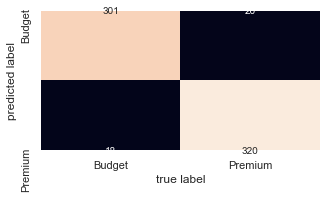

In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = axis, yticklabels = axis)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [20]:
mat

array([[301,  18],
       [ 20, 320]], dtype=int64)

Naive Bayes

In [21]:
description = df['description']

In [22]:
description_array = np.array(description.values.tolist())

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(description_array, Premium_NonPremium, test_size=0.2, random_state=100)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

NB_model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [25]:
NB_model.fit(X_train, y_train)
y_pred_nb = NB_model.predict(X_test)

In [26]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(NB_model, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.98863636 0.98106061 0.98863636 0.98106061 0.96577947 0.99239544
 0.98859316 0.98859316 0.97718631 0.99618321]


In [27]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.9657794676806084, 0.9848124674017921, 0.9961832061068703)

In [28]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_nb))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_nb, average='weighted')))

Testing accuracy 0.9711684370257967
Testing F1 score: 0.9711390146862073


Text(21.453125, 0.5, 'predicted label')

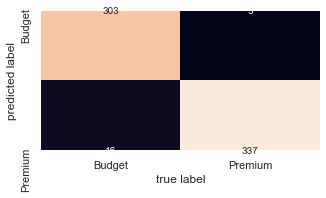

In [29]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = axis, yticklabels = axis)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [30]:
mat

array([[303,  16],
       [  3, 337]], dtype=int64)

Some basic neural network models

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

In [32]:
#Split dataset into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Doc_Vec_array, Premium_NonPremium, test_size=0.2, random_state=100)

In [33]:
clf_V1 = MLPClassifier(hidden_layer_sizes = (100), verbose = True).fit(X_train, y_train)

Iteration 1, loss = 0.47188884
Iteration 2, loss = 0.19780477
Iteration 3, loss = 0.12677432
Iteration 4, loss = 0.09565694
Iteration 5, loss = 0.07745176
Iteration 6, loss = 0.06283955
Iteration 7, loss = 0.05325674
Iteration 8, loss = 0.04567673
Iteration 9, loss = 0.03993266
Iteration 10, loss = 0.03519552
Iteration 11, loss = 0.03097189
Iteration 12, loss = 0.02781145
Iteration 13, loss = 0.02519471
Iteration 14, loss = 0.02308248
Iteration 15, loss = 0.02067237
Iteration 16, loss = 0.01903714
Iteration 17, loss = 0.01820017
Iteration 18, loss = 0.01615006
Iteration 19, loss = 0.01475710
Iteration 20, loss = 0.01362111
Iteration 21, loss = 0.01258300
Iteration 22, loss = 0.01147995
Iteration 23, loss = 0.01068131
Iteration 24, loss = 0.00989340
Iteration 25, loss = 0.00921479
Iteration 26, loss = 0.00854938
Iteration 27, loss = 0.00797392
Iteration 28, loss = 0.00749300
Iteration 29, loss = 0.00693899
Iteration 30, loss = 0.00647885
Iteration 31, loss = 0.00610266
Iteration 32, los

In [34]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_V1, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Iteration 1, loss = 0.58766394
Iteration 2, loss = 0.28302798
Iteration 3, loss = 0.18000706
Iteration 4, loss = 0.13110274
Iteration 5, loss = 0.10324668
Iteration 6, loss = 0.08467110
Iteration 7, loss = 0.07126627
Iteration 8, loss = 0.06071655
Iteration 9, loss = 0.05255930
Iteration 10, loss = 0.04647973
Iteration 11, loss = 0.04103166
Iteration 12, loss = 0.03682285
Iteration 13, loss = 0.03292072
Iteration 14, loss = 0.02954141
Iteration 15, loss = 0.02683738
Iteration 16, loss = 0.02428461
Iteration 17, loss = 0.02238692
Iteration 18, loss = 0.02037415
Iteration 19, loss = 0.01879224
Iteration 20, loss = 0.01740434
Iteration 21, loss = 0.01600059
Iteration 22, loss = 0.01493603
Iteration 23, loss = 0.01395300
Iteration 24, loss = 0.01283998
Iteration 25, loss = 0.01201155
Iteration 26, loss = 0.01138279
Iteration 27, loss = 0.01050509
Iteration 28, loss = 0.00982439
Iteration 29, loss = 0.00922596
Iteration 30, loss = 0.00862713
Iteration 31, loss = 0.00814283
Iteration 32, los

Iteration 64, loss = 0.00152878
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.52050997
Iteration 2, loss = 0.24902882
Iteration 3, loss = 0.15358025
Iteration 4, loss = 0.11157420
Iteration 5, loss = 0.08759655
Iteration 6, loss = 0.07114667
Iteration 7, loss = 0.05928777
Iteration 8, loss = 0.05061946
Iteration 9, loss = 0.04380480
Iteration 10, loss = 0.03818555
Iteration 11, loss = 0.03433246
Iteration 12, loss = 0.03033991
Iteration 13, loss = 0.02720705
Iteration 14, loss = 0.02461155
Iteration 15, loss = 0.02245003
Iteration 16, loss = 0.02063000
Iteration 17, loss = 0.01879568
Iteration 18, loss = 0.01726642
Iteration 19, loss = 0.01610551
Iteration 20, loss = 0.01489505
Iteration 21, loss = 0.01380661
Iteration 22, loss = 0.01279925
Iteration 23, loss = 0.01191146
Iteration 24, loss = 0.01109527
Iteration 25, loss = 0.01035840
Iteration 26, loss = 0.00969386
Iteration 27, loss = 0.00899348
Iteration 28, loss = 0.

Iteration 5, loss = 0.09571892
Iteration 6, loss = 0.07918392
Iteration 7, loss = 0.06705744
Iteration 8, loss = 0.05704141
Iteration 9, loss = 0.04985246
Iteration 10, loss = 0.04360702
Iteration 11, loss = 0.03871144
Iteration 12, loss = 0.03464963
Iteration 13, loss = 0.03116846
Iteration 14, loss = 0.02823784
Iteration 15, loss = 0.02570420
Iteration 16, loss = 0.02347640
Iteration 17, loss = 0.02150608
Iteration 18, loss = 0.01973674
Iteration 19, loss = 0.01821628
Iteration 20, loss = 0.01686867
Iteration 21, loss = 0.01563042
Iteration 22, loss = 0.01451030
Iteration 23, loss = 0.01346583
Iteration 24, loss = 0.01255723
Iteration 25, loss = 0.01168979
Iteration 26, loss = 0.01090333
Iteration 27, loss = 0.01024207
Iteration 28, loss = 0.00961510
Iteration 29, loss = 0.00895814
Iteration 30, loss = 0.00838435
Iteration 31, loss = 0.00790260
Iteration 32, loss = 0.00741282
Iteration 33, loss = 0.00691017
Iteration 34, loss = 0.00651917
Iteration 35, loss = 0.00613241
Iteration 36,

In [35]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.9507575757575758, 0.9662071693629178, 0.9809160305343512)

In [36]:
y_pred_clf1 = clf_V1.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_clf1))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_clf1, average='weighted')))

Testing accuracy 0.9514415781487102
Testing F1 score: 0.9514491865209518


Text(21.453125, 0.5, 'predicted label')

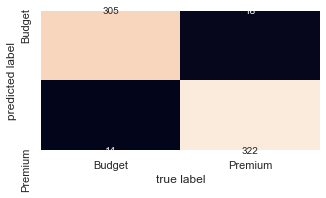

In [38]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred_clf1)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = axis, yticklabels = axis)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [39]:
mat

array([[305,  14],
       [ 18, 322]], dtype=int64)

With 4 hidden lyaers of 100, 100, 100, 50 units respectively

In [40]:
clf_V2 = MLPClassifier(hidden_layer_sizes = (100, 100, 100, 50),  verbose = True).fit(X_train, y_train)

Iteration 1, loss = 0.57543050
Iteration 2, loss = 0.19110835
Iteration 3, loss = 0.09327222
Iteration 4, loss = 0.04753377
Iteration 5, loss = 0.02956829
Iteration 6, loss = 0.01876493
Iteration 7, loss = 0.01295301
Iteration 8, loss = 0.01153568
Iteration 9, loss = 0.00857756
Iteration 10, loss = 0.00649849
Iteration 11, loss = 0.00422588
Iteration 12, loss = 0.00251539
Iteration 13, loss = 0.00134016
Iteration 14, loss = 0.00092860
Iteration 15, loss = 0.00067416
Iteration 16, loss = 0.00053355
Iteration 17, loss = 0.00043749
Iteration 18, loss = 0.00037228
Iteration 19, loss = 0.00032920
Iteration 20, loss = 0.00029738
Iteration 21, loss = 0.00026993
Iteration 22, loss = 0.00025011
Iteration 23, loss = 0.00023294
Iteration 24, loss = 0.00021873
Iteration 25, loss = 0.00020739
Iteration 26, loss = 0.00019859
Iteration 27, loss = 0.00018975
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [41]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_V2, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Iteration 1, loss = 0.53277423
Iteration 2, loss = 0.20358576
Iteration 3, loss = 0.09412272
Iteration 4, loss = 0.05019035
Iteration 5, loss = 0.03203578
Iteration 6, loss = 0.02012716
Iteration 7, loss = 0.01435167
Iteration 8, loss = 0.01084833
Iteration 9, loss = 0.00832878
Iteration 10, loss = 0.00678981
Iteration 11, loss = 0.00481199
Iteration 12, loss = 0.00327757
Iteration 13, loss = 0.00172143
Iteration 14, loss = 0.00112603
Iteration 15, loss = 0.00082112
Iteration 16, loss = 0.00062864
Iteration 17, loss = 0.00051674
Iteration 18, loss = 0.00044216
Iteration 19, loss = 0.00038659
Iteration 20, loss = 0.00034608
Iteration 21, loss = 0.00031551
Iteration 22, loss = 0.00028848
Iteration 23, loss = 0.00026896
Iteration 24, loss = 0.00025100
Iteration 25, loss = 0.00023694
Iteration 26, loss = 0.00022379
Iteration 27, loss = 0.00021404
Iteration 28, loss = 0.00020370
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.5

Iteration 24, loss = 0.00021951
Iteration 25, loss = 0.00020930
Iteration 26, loss = 0.00020046
Iteration 27, loss = 0.00019261
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.61705184
Iteration 2, loss = 0.25878670
Iteration 3, loss = 0.11305803
Iteration 4, loss = 0.06070328
Iteration 5, loss = 0.03699266
Iteration 6, loss = 0.02597990
Iteration 7, loss = 0.01668734
Iteration 8, loss = 0.01192193
Iteration 9, loss = 0.00886966
Iteration 10, loss = 0.00605812
Iteration 11, loss = 0.00470480
Iteration 12, loss = 0.00317658
Iteration 13, loss = 0.00226220
Iteration 14, loss = 0.00140157
Iteration 15, loss = 0.00101869
Iteration 16, loss = 0.00073405
Iteration 17, loss = 0.00058718
Iteration 18, loss = 0.00049224
Iteration 19, loss = 0.00042833
Iteration 20, loss = 0.00037772
Iteration 21, loss = 0.00033996
Iteration 22, loss = 0.00031105
Iteration 23, loss = 0.00028615
Iteration 24, loss = 0.00026649
Iteration 25, loss = 0.

In [42]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.9431818181818182, 0.9643031151793089, 0.9734848484848485)

In [43]:
y_pred_clf2 = clf_V2.predict(X_test)

In [44]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_clf2))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_clf2, average='weighted')))

Testing accuracy 0.9499241274658573
Testing F1 score: 0.9499303587217579


Text(21.453125, 0.5, 'predicted label')

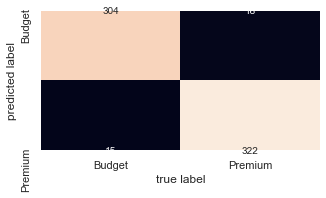

In [45]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred_clf2)
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels = axis, yticklabels = axis)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [46]:
mat

array([[304,  15],
       [ 18, 322]], dtype=int64)

 hyper-parameter optimization

In [51]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(100,100,100,50),(100,100,50),(100,50),(100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=100,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes

In [52]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [53]:
y_pred_clf_tune = clf.predict(X_test)

In [54]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred_clf_tune))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_clf_tune, average='weighted')))

Testing accuracy 0.952959028831563
Testing F1 score: 0.9529648824355909
